In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")

data = pd.read_csv("./metadata.csv")

In [3]:
filled_df_map = data[["age", "bleed", "grew",  "itch", "elevation", "changed", "background_mother", "background_father",
                      "has_sewage_system", "region", "smoke", 'gender', 'pesticide', "fitspatrick", "hurt", "diagnostic"]]

map_cat=["bleed", "grew", "itch", "elevation", "changed", "background_mother", "background_father" ,"has_sewage_system", 
         "region", "smoke", 'gender', 'pesticide', "fitspatrick", "hurt", "diagnostic"]

In [4]:
import seaborn as sns
import scipy.stats as ss
def cramers_corrected_stat(df,cat_col1,cat_col2):
    """
    This function spits out corrected Cramer's correlation statistic
    between two categorical columns of a dataframe 
    """
    crosstab = pd.crosstab(df[cat_col1],df[cat_col2])
    chi_sqr = ss.chi2_contingency(crosstab)[0]
    n = crosstab.sum().sum()
    r,k = crosstab.shape
    phi_sqr_corr = max(0, chi_sqr/n - ((k-1)*(r-1))/(n-1))    
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    
    result = np.sqrt(phi_sqr_corr / min( (k_corr-1), (r_corr-1)))
    return round(result,3)

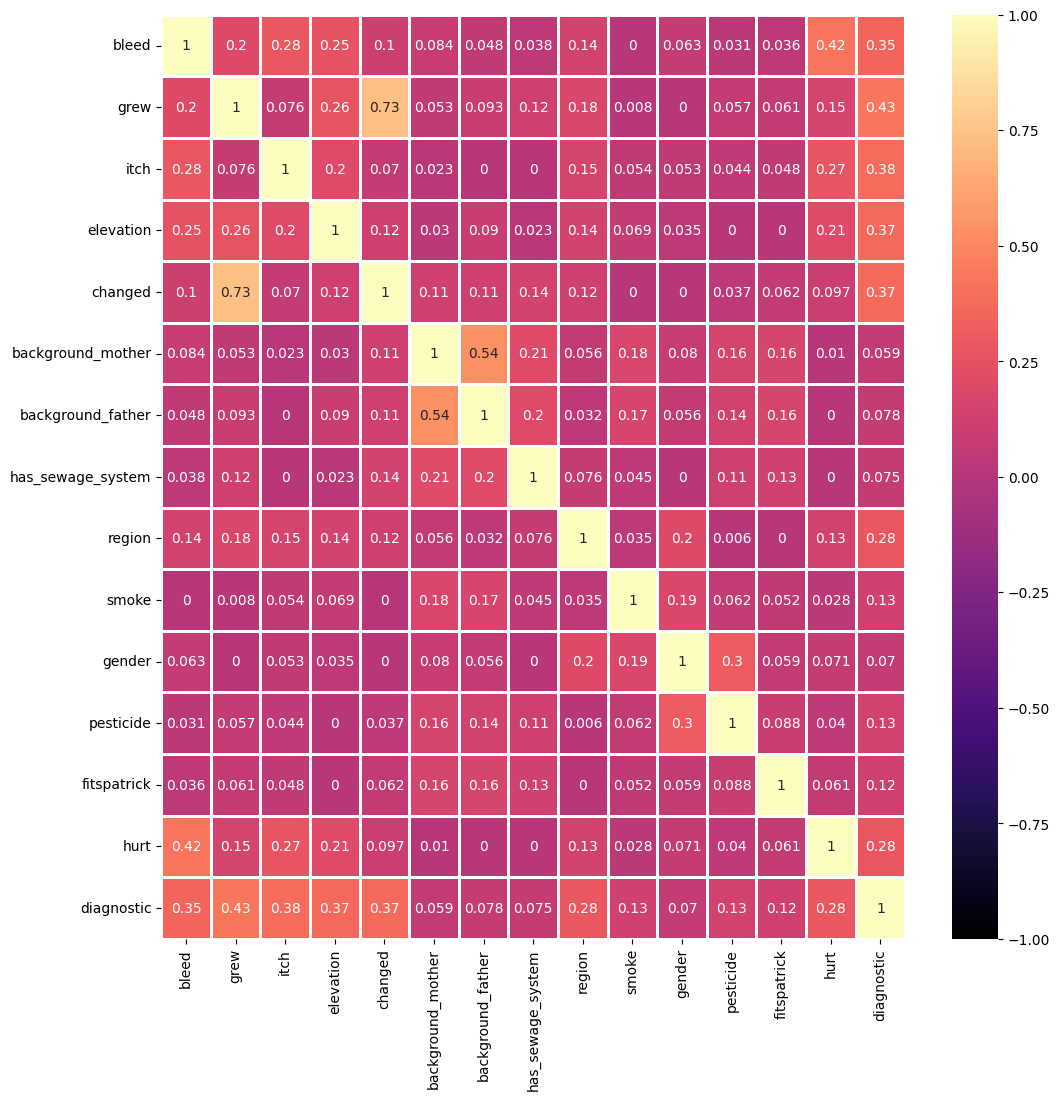

In [15]:
import matplotlib.pyplot as plt
cramer_v_corr = dict(zip(map_cat,[[cramers_corrected_stat(filled_df_map,f1,f2) for f2 in map_cat] for f1 in map_cat]))
plt.figure(figsize=(12,12),dpi=100)
sns.heatmap(data=pd.DataFrame(data=cramer_v_corr,index=map_cat),
            cmap='magma',
            linecolor='white',
            linewidth=1,
            annot=True,
            vmin=-1,
            vmax=1);
plt.savefig("images/cramer_v_corr.png", dpi=200)

In [6]:
data_ = data.dropna()
X = data_.drop(['patient_id', 'lesion_id','img_id', 'biopsed', "diagnostic"], axis=1)
y = data_["diagnostic"]

from sklearn.model_selection import train_test_split
X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)

In [7]:
from sklearn.ensemble import RandomForestClassifier

feature_names = X_encoded.columns
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [8]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.009 seconds


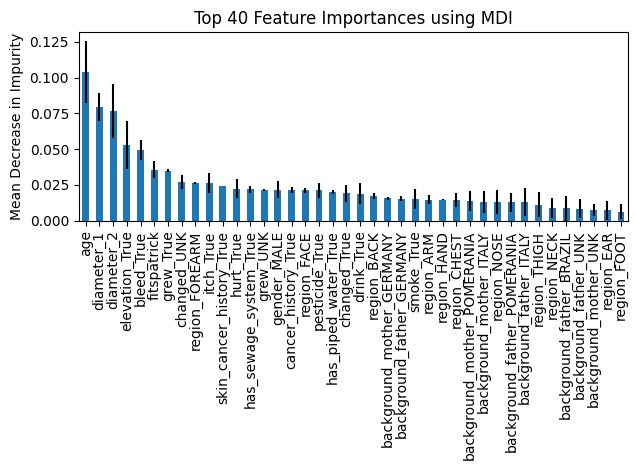

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

top_n = 40
forest_importances = forest_importances[:top_n]
std = std[:top_n]

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Top {} Feature Importances using MDI".format(top_n))
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()
plt.show()

In [10]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=40, random_state=42, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

Elapsed time to compute the importances: 8.081 seconds


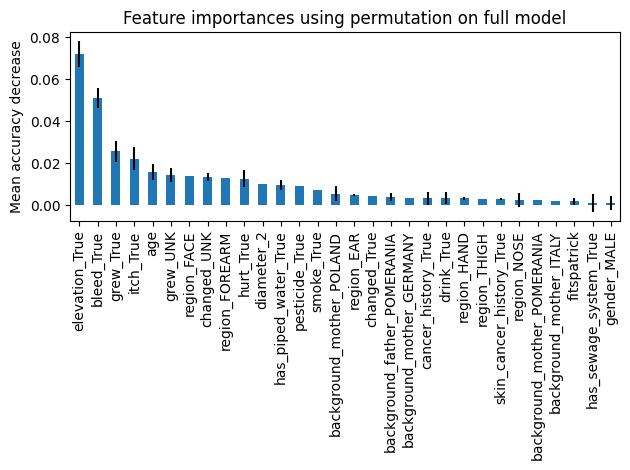

In [14]:
fig, ax = plt.subplots()
top_n = 30
forest_importances = forest_importances[:top_n]
forest_importances.plot.bar(yerr=result.importances_std[:top_n] , ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.savefig("images/feature_importances_using_permutation_on_full_model.png", dpi=200)
plt.show()

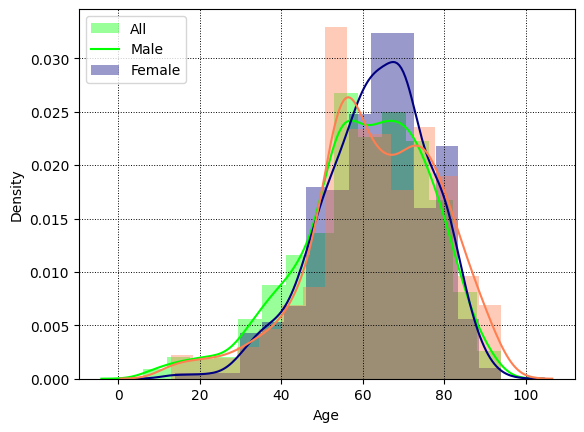

<Figure size 640x480 with 0 Axes>

In [13]:
kde = True
male = data[ data['gender'] == 'MALE' ]
female = data[ data['gender'] == 'FEMALE' ]


sns.distplot(data['age'], color="lime", label='All', kde=kde, bins=15)
sns.distplot(male['age'], color="navy", label='Male', kde=kde, bins=15)
sns.distplot(female['age'], color="coral", label='Female', kde=kde, bins=15)
plt.grid(color='black', linestyle='dotted', linewidth=0.7)
plt.xlabel("Age")
plt.legend(['All', 'Male', 'Female'], loc='upper left')
plt.savefig("images/age_distribution.png", dpi=200)
plt.figure();

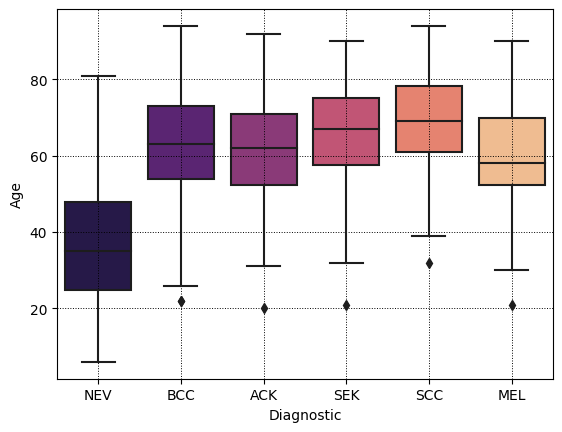

<Figure size 640x480 with 0 Axes>

In [37]:
sns.boxplot(y='age', x='diagnostic', data=data, palette="magma")
plt.grid(color='black', linestyle='dotted', linewidth=0.7)
plt.xlabel("Diagnostic")
plt.ylabel("Age")
plt.savefig("images/age_boxplot.png", dpi=200)
plt.figure();

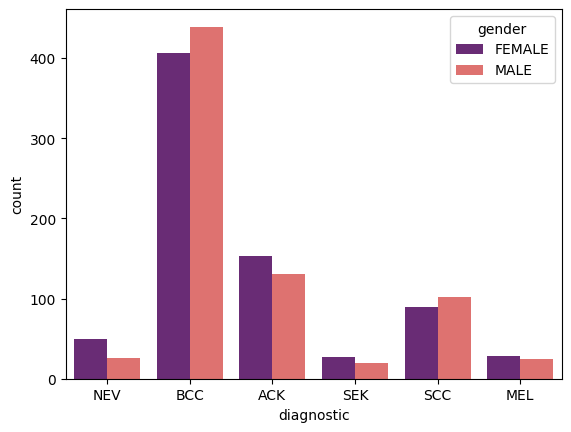

In [16]:
x = sns.countplot(x="diagnostic", hue="gender", data=data, palette="magma")
plt.savefig('images/gender_per_diag.png', dpi = 200);

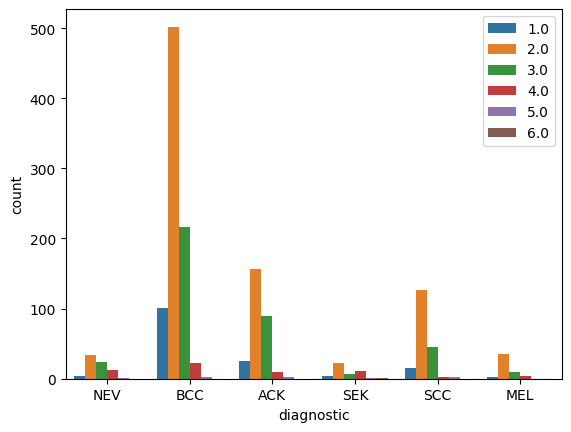

In [63]:
x = sns.countplot(x="diagnostic", hue="fitspatrick", data=data)
plt.legend(loc='upper right')
plt.savefig('images/fitspatrick.png', dpi = 200);

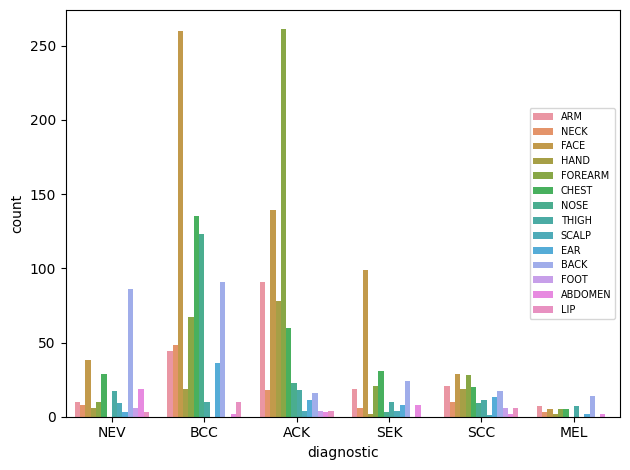

In [17]:
x = sns.countplot(x="diagnostic", hue="region", data=data)
plt.legend(loc='right', prop={'size': 7})
plt.tight_layout()
plt.savefig('images/regions_per_diag.png', dpi = 200);

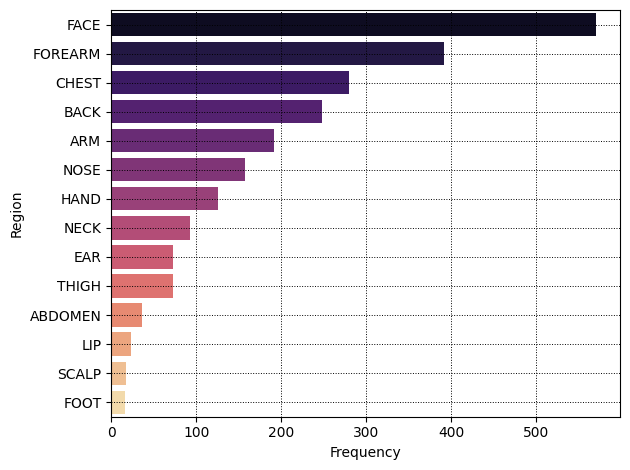

<Figure size 640x480 with 0 Axes>

In [18]:
x = data.groupby(['region']).count()['diagnostic'].sort_values(ascending=False)
sns.barplot(x=x.values, y=x.index, palette="magma", orient='h')
plt.grid(color='black', linestyle='dotted', linewidth=0.7)
plt.xlabel("Frequency")
plt.ylabel("Region")
plt.tight_layout()
plt.savefig("images/region_frequency.png", dpi=200)
plt.figure();


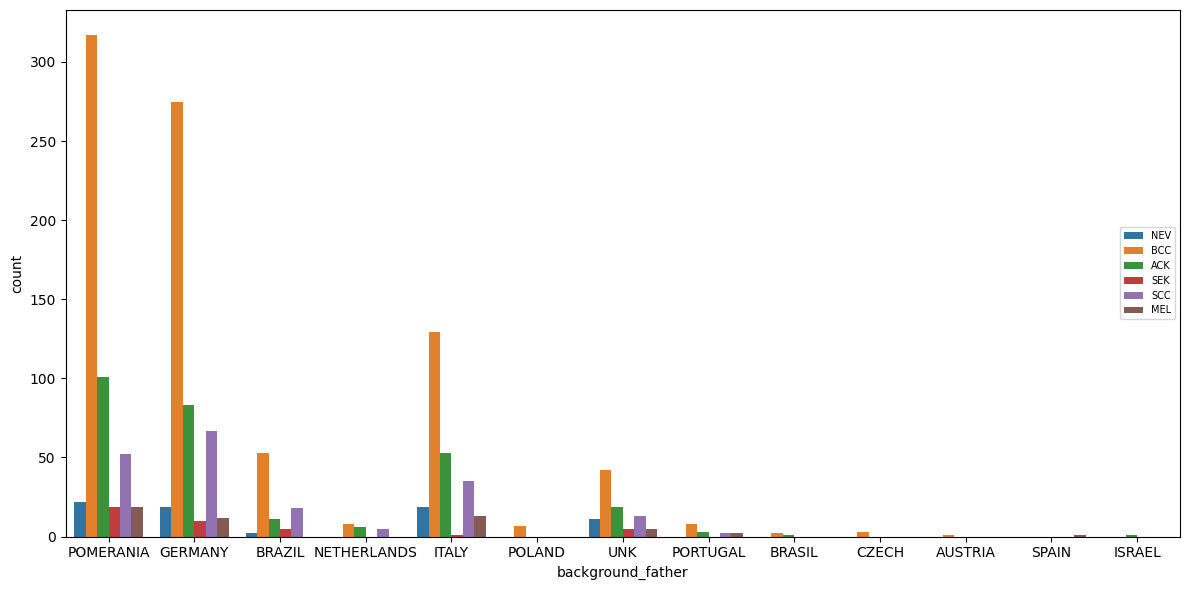

In [19]:
plt.figure(figsize=(12, 6))  # Set the figure size as desired (width, height)
x = sns.countplot(x="background_father", hue="diagnostic", data=data)
plt.legend(loc='right', prop={'size': 7})
plt.tight_layout()
plt.savefig('images/regions_per_diag.png', dpi=200);

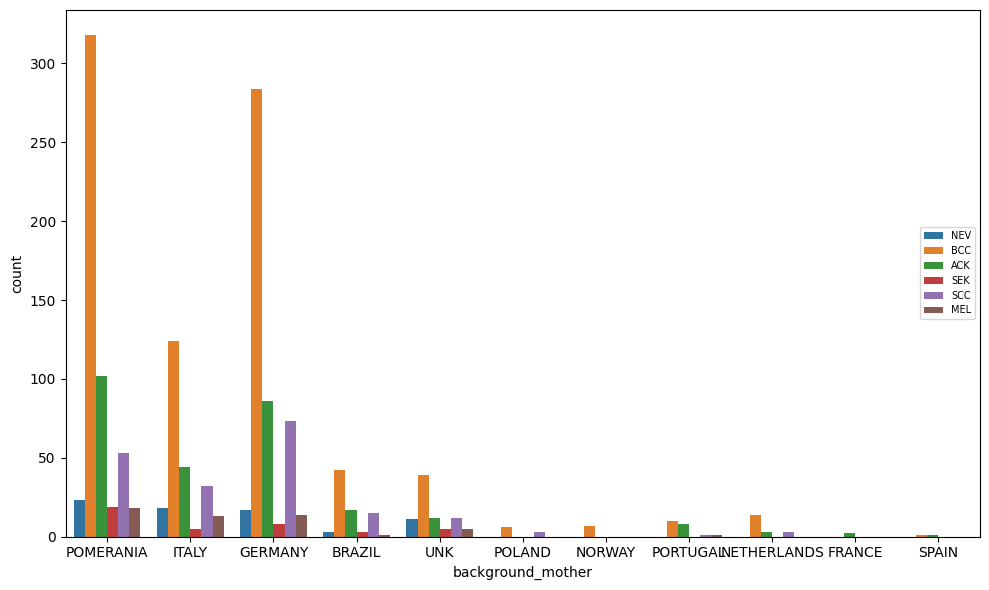

In [20]:
plt.figure(figsize=(10, 6))  # Set the figure size as desired (width, height)
x = sns.countplot(x="background_mother", hue="diagnostic", data=data)
plt.legend(loc='right', prop={'size': 7})
plt.tight_layout()
plt.savefig('images/regions_per_diag.png', dpi=200);

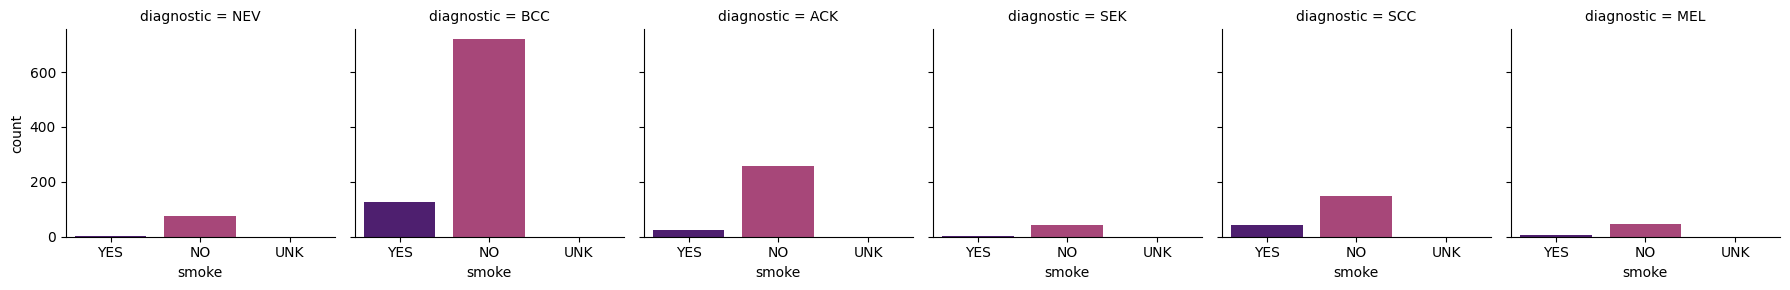

<Figure size 640x480 with 0 Axes>

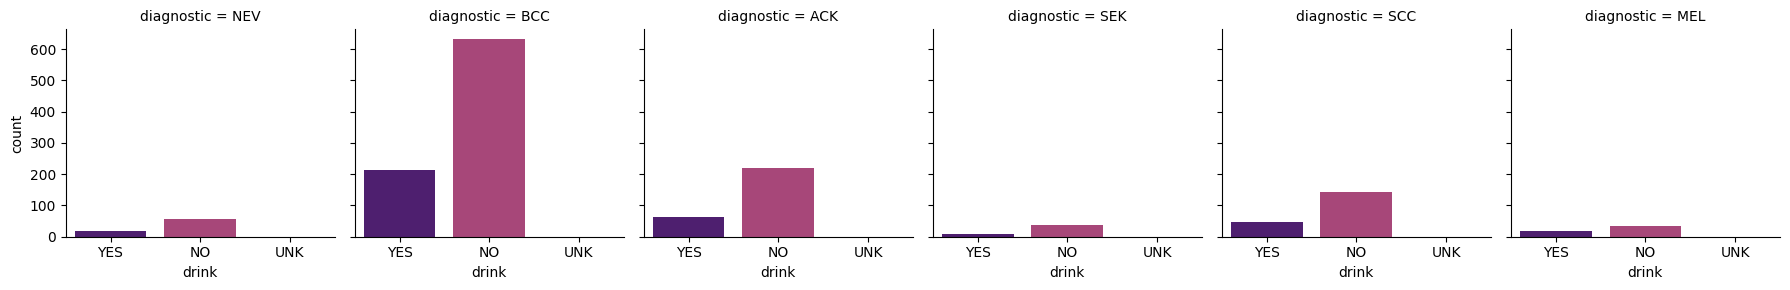

<Figure size 640x480 with 0 Axes>

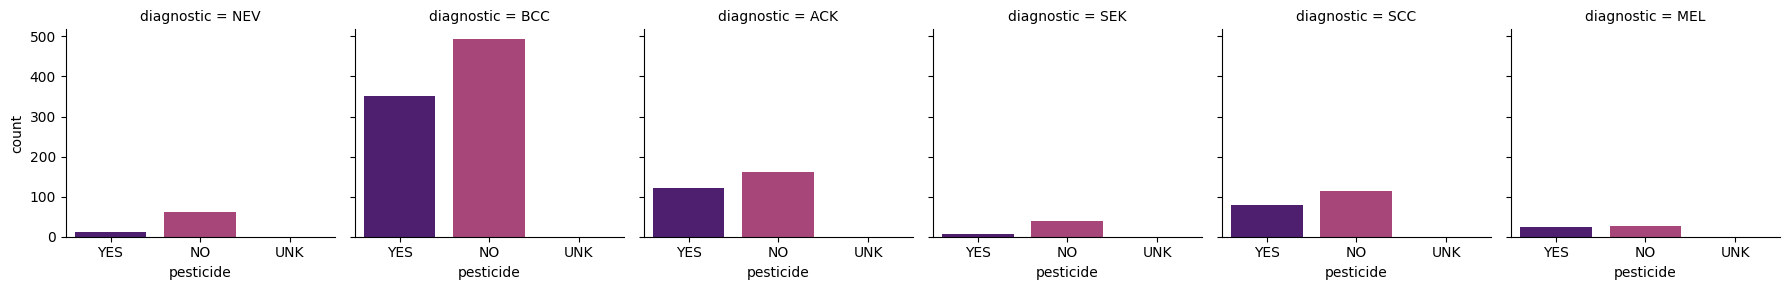

<Figure size 640x480 with 0 Axes>

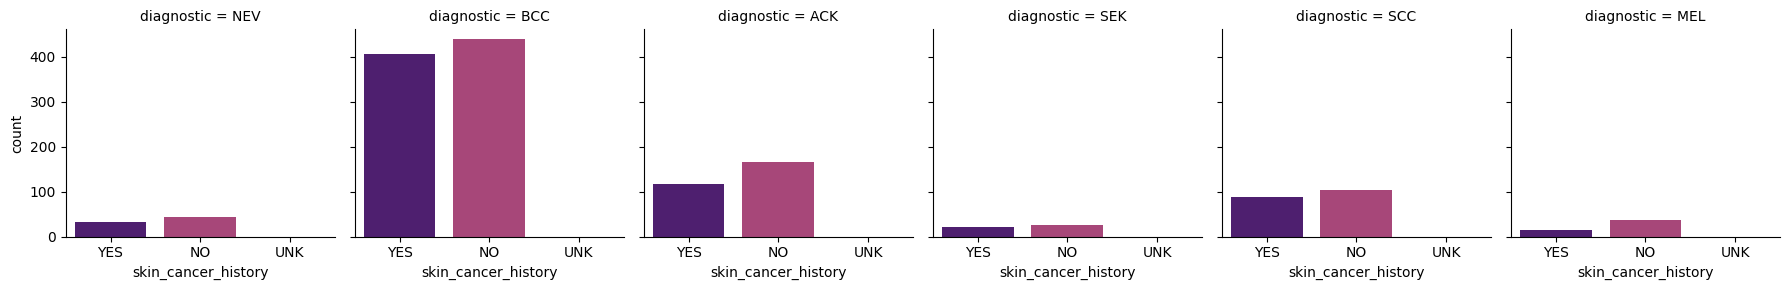

<Figure size 640x480 with 0 Axes>

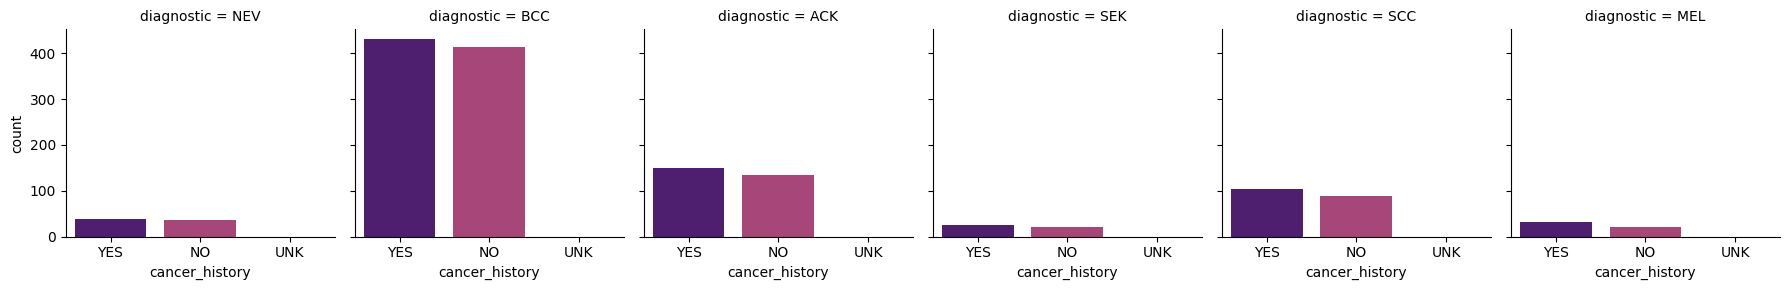

<Figure size 640x480 with 0 Axes>

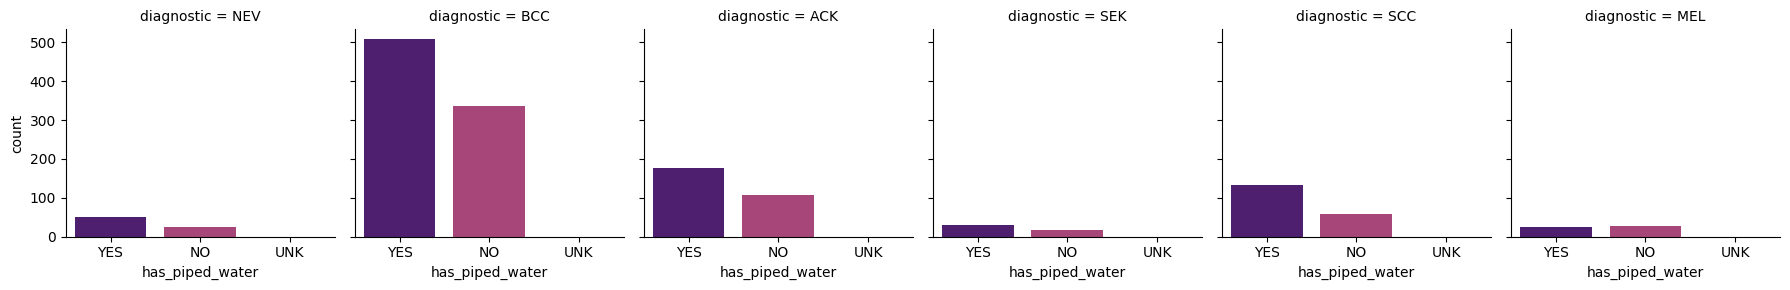

<Figure size 640x480 with 0 Axes>

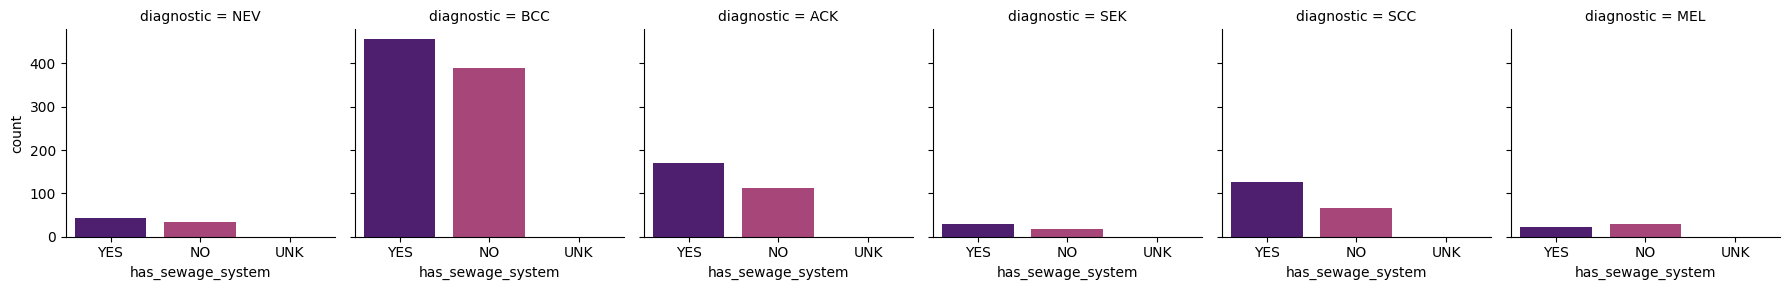

<Figure size 640x480 with 0 Axes>

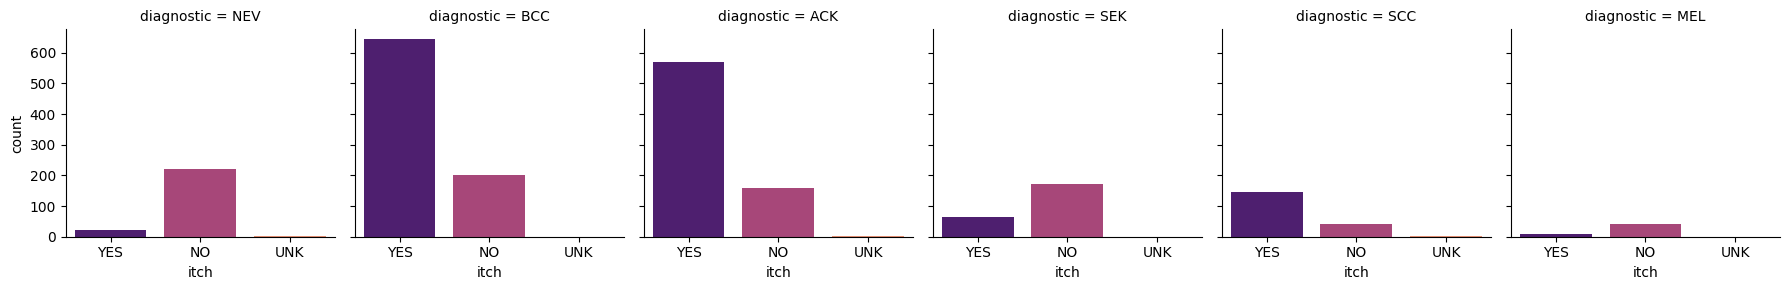

<Figure size 640x480 with 0 Axes>

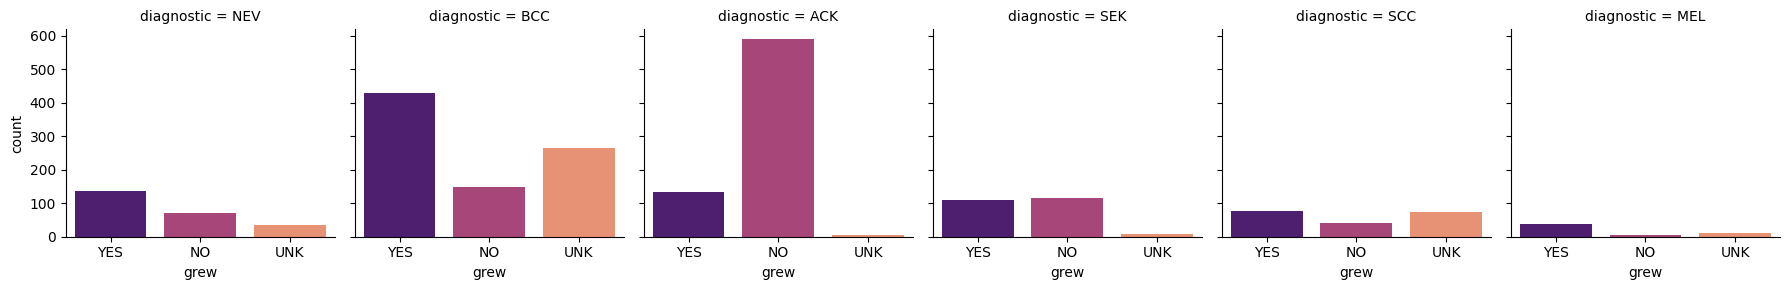

<Figure size 640x480 with 0 Axes>

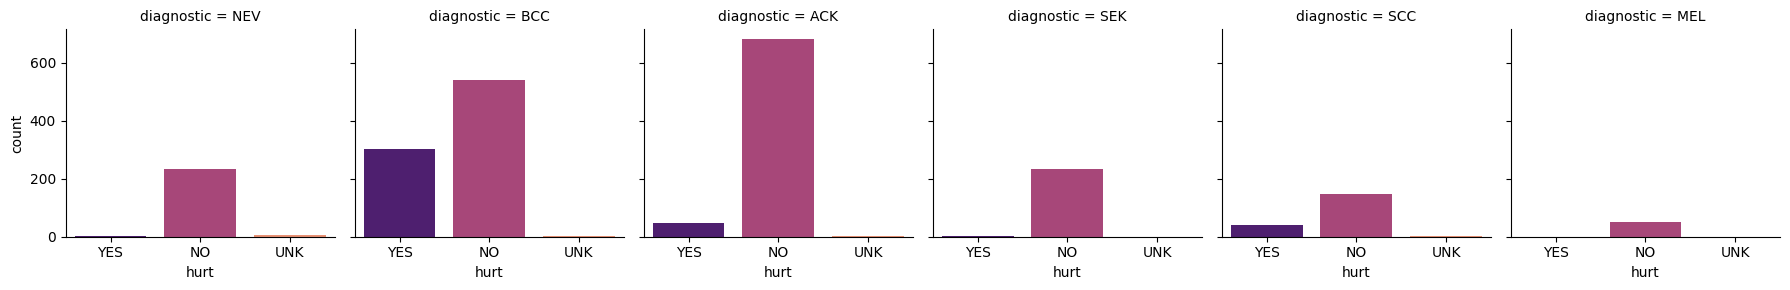

<Figure size 640x480 with 0 Axes>

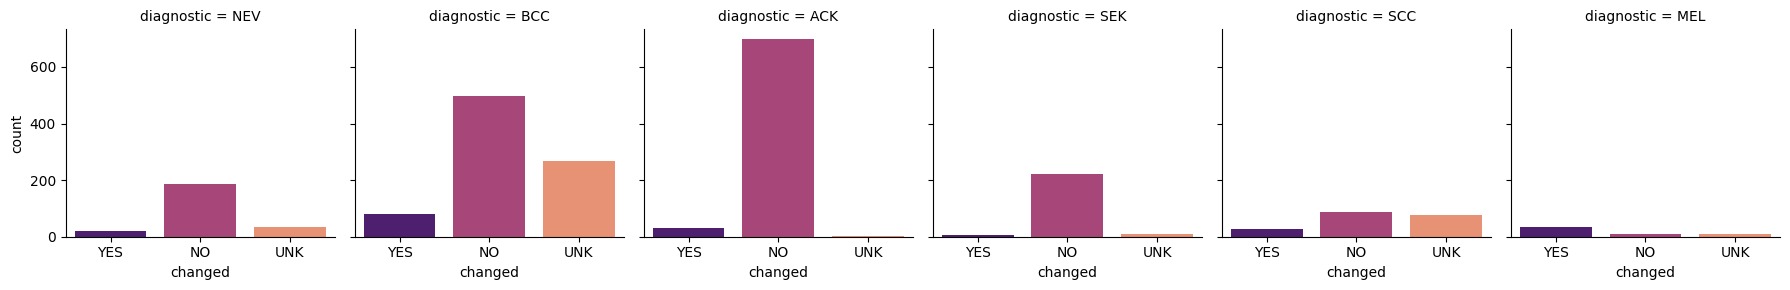

<Figure size 640x480 with 0 Axes>

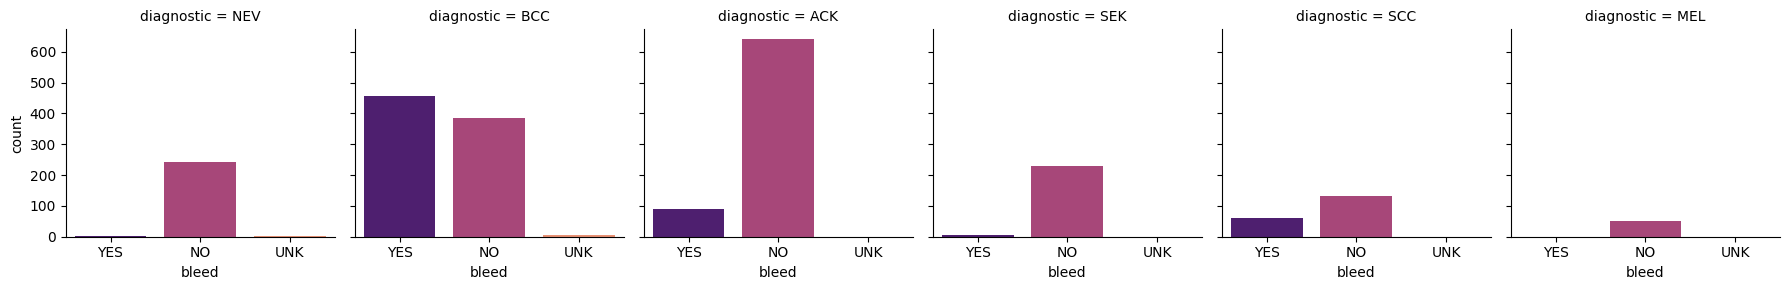

<Figure size 640x480 with 0 Axes>

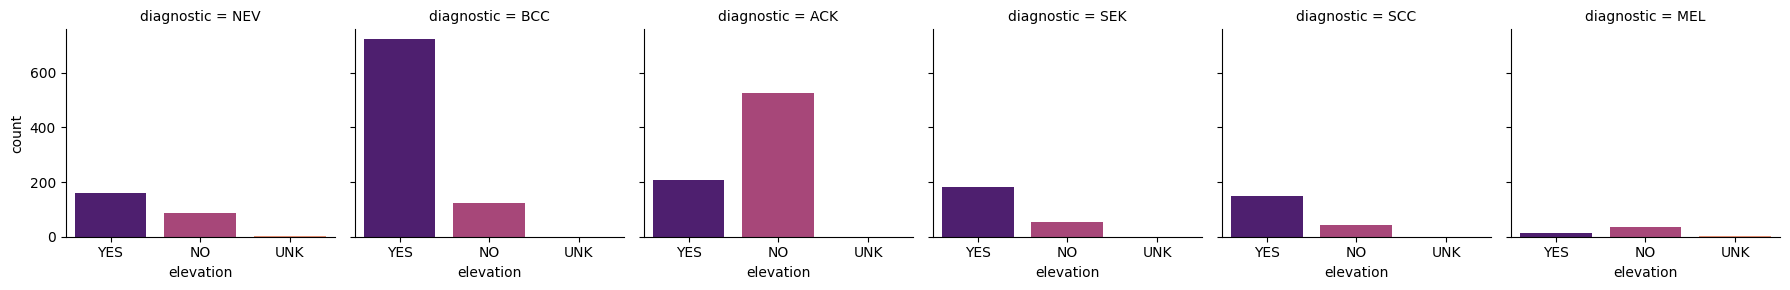

<Figure size 640x480 with 0 Axes>

In [40]:
data_ = data.replace({'True': 'YES', 'False': 'NO', True: 'YES', False: 'NO'})
_feats = ['smoke', 'drink', 'pesticide', 'skin_cancer_history', 'cancer_history', 'has_piped_water',
       'has_sewage_system', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation']

def plot_count (_feat):    
    sub_data = data_[[_feat, 'diagnostic']]            
    g = sns.FacetGrid(sub_data, col="diagnostic")    
    g.map(sns.countplot, _feat, order=['YES', 'NO', 'UNK'], palette="magma")       
    g.savefig("images/count_{}.png".format(_feat), dpi=200)    
    plt.figure()


for _feat in _feats:
    plot_count(_feat)
    